In [1]:
from function import *
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

sns.set(style="whitegrid")

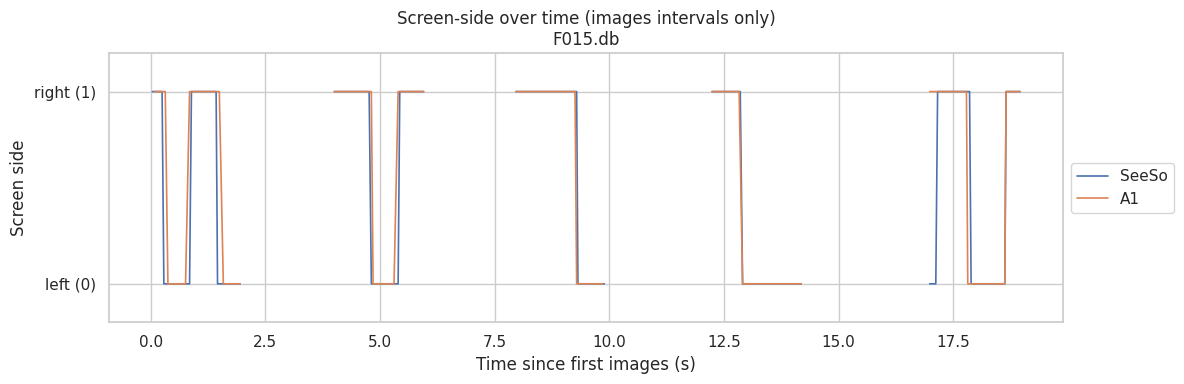

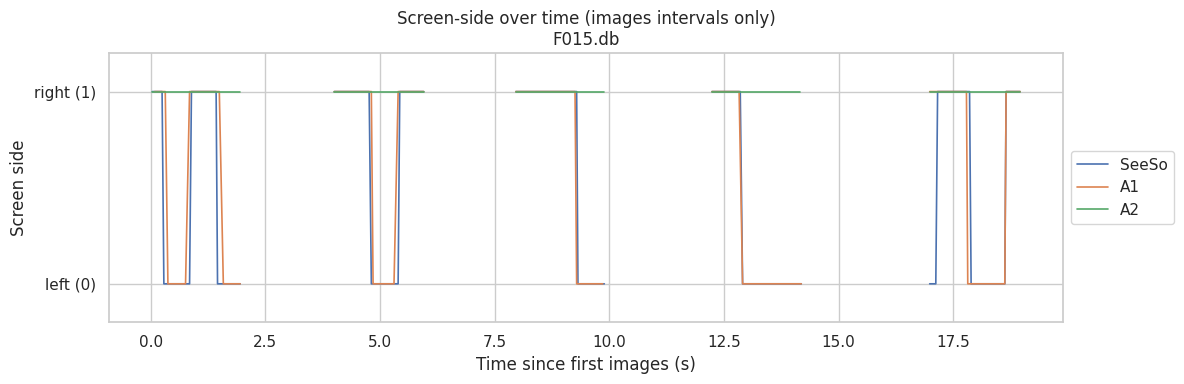

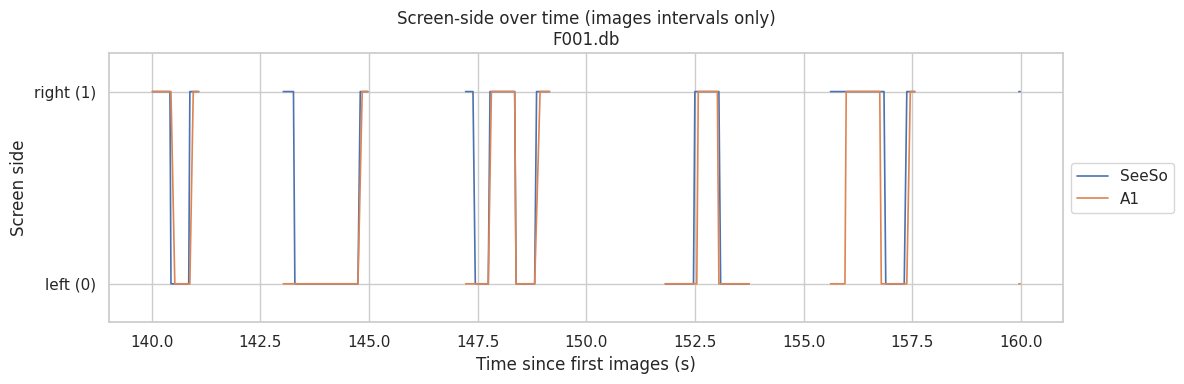

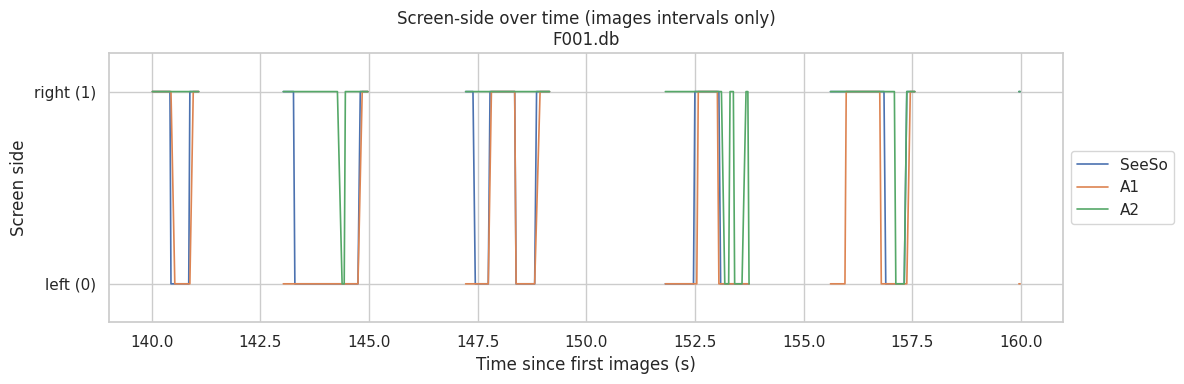

In [2]:
db_file = Path("db") / "F018.db"

# Zoom sur les 20 premières secondes
plot_db_side_over_time("db/F015.db", t_start_s=0, t_end_s=20)


plot_db_side_over_time("db/F001.db", t_start_s=140, t_end_s=160)

In [3]:
df_sessions, df_pairs, sessions = analyze_all_dbs("db")

In [4]:
df_pairs.groupby("other_tracker")

In [13]:
df_mean_multi = (
    df_pairs[df_pairs["other_tracker"] == "A1"].groupby("other_tracker")[[
        "roi_prop_in_aoi_given_side_strict",
        "roi_prop_in_aoi_given_side_5",
        "roi_prop_in_aoi_given_side_10",
        #"roi_prop_in_aoi_given_side_20",
    ]]
    .mean()
    .reset_index()
    .rename(columns={"other_tracker": "tracker"})
)

In [14]:
seeso_sessions = [s for s in sessions if s["tracker"] == "SeeSo"]

strict_vals = []
m5_vals = []
m10_vals = []
m20_vals = []

for s in seeso_sessions:
    g = s["gaze_zoned"]
    strict_vals.append((g["zone"] != "none").mean())
    m5_vals.append((g["zone_margin_5"] != "none").mean())
    m10_vals.append((g["zone_margin_10"] != "none").mean())
    #m20_vals.append((g["zone_margin_20"] != "none").mean())

seeso_row = {
    "tracker": "seeso",
    "roi_prop_in_aoi_given_side_strict": float(np.mean(strict_vals)),
    "roi_prop_in_aoi_given_side_5":      float(np.mean(m5_vals)),
    "roi_prop_in_aoi_given_side_10":     float(np.mean(m10_vals)),
    #"roi_prop_in_aoi_given_side_20":     float(np.mean(m20_vals)),
}


df_mean_multi = pd.concat([df_mean_multi, pd.DataFrame([seeso_row])], ignore_index=True)

In [15]:
# Calculer les moyennes par tracker Python (pyGaze + pyMPIIGaze)
df_mean = (
    df_pairs
    .groupby("other_tracker")[[
        "screen_side_agreement_time",
        "roi_time_in_aoi_given_side",
        "roi_time_in_aoi_margin_given_side",
        "err_mean_px",
        "err_rmse_px",
        "err_p95_px",
    ]]
    .mean()
    .reset_index()
    .rename(columns={"other_tracker": "tracker"})
)


df_plot = pd.concat([df_mean, pd.DataFrame([seeso_row])], ignore_index=True)

df_plot


,tracker,screen_side_agreement_time,roi_time_in_aoi_given_side,roi_time_in_aoi_margin_given_side,err_mean_px,err_rmse_px,err_p95_px,roi_prop_in_aoi_given_side_strict,roi_prop_in_aoi_given_side_5,roi_prop_in_aoi_given_side_10
0,A1,0.751385,0.325872,0.514713,243.913884,270.345388,431.821011,NaN,NaN,NaN
1,A2,0.558920,0.191282,0.434489,317.148980,351.029535,571.494670,NaN,NaN,NaN
2,seeso,NaN,NaN,NaN,NaN,NaN,NaN,0.35457,0.3806,0.404123


/tmp/ipykernel_17907/3684882813.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_screen, x="tracker", y="screen_side_agreement_time", palette="viridis")


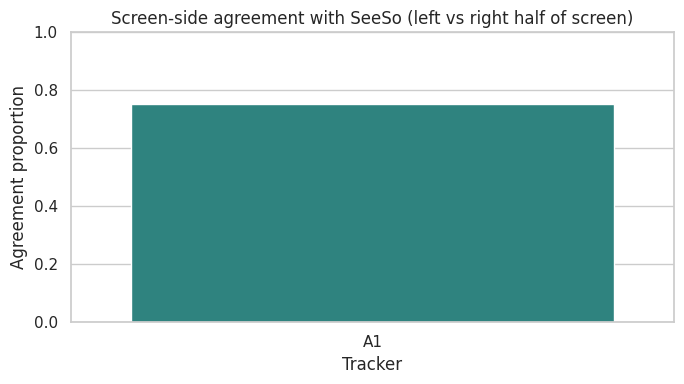

In [8]:
df_screen = df_mean[df_mean["tracker"] == "A1"]

plt.figure(figsize=(7,4))
sns.barplot(data=df_screen, x="tracker", y="screen_side_agreement_time", palette="viridis")

plt.title("Screen-side agreement with SeeSo (left vs right half of screen)")
plt.ylabel("Agreement proportion")
plt.xlabel("Tracker")
plt.ylim(0, 1)
plt.tight_layout()
plt.show()


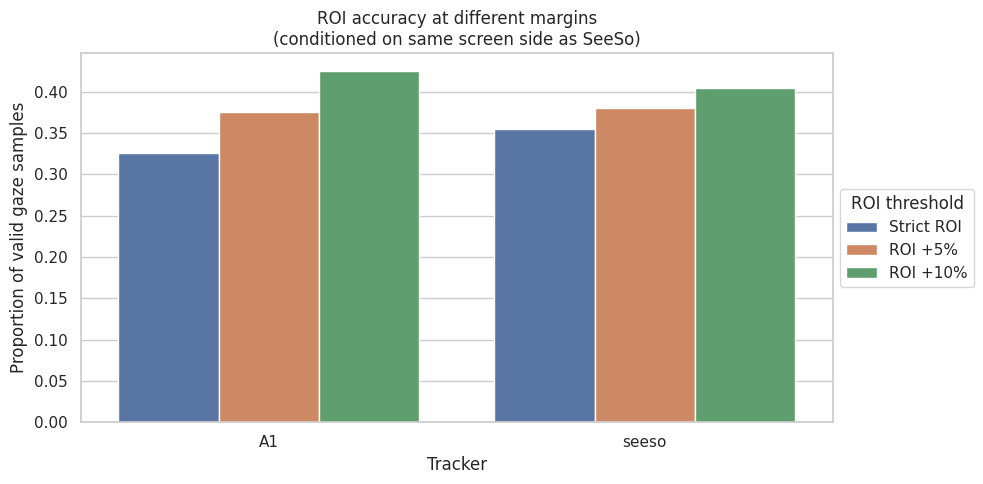

In [16]:
df_roi_plot = df_mean_multi.melt(
    id_vars="tracker",
    value_vars=[
        "roi_prop_in_aoi_given_side_strict",
        "roi_prop_in_aoi_given_side_5",
        "roi_prop_in_aoi_given_side_10",
        #"roi_prop_in_aoi_given_side_20",
    ],
    var_name="metric",
    value_name="value"
)

df_roi_plot["metric"] = df_roi_plot["metric"].map({
    "roi_prop_in_aoi_given_side_strict": "Strict ROI",
    "roi_prop_in_aoi_given_side_5":      "ROI +5%",
    "roi_prop_in_aoi_given_side_10":     "ROI +10%",
    #"roi_prop_in_aoi_given_side_20":     "ROI +20%",
})

# 5) Plot   
plt.figure(figsize=(10, 5))
sns.barplot(data=df_roi_plot, x="tracker", y="value", hue="metric")
plt.title("ROI accuracy at different margins\n(conditioned on same screen side as SeeSo)")
plt.xlabel("Tracker")
plt.ylabel("Proportion of valid gaze samples")
ymax = df_roi_plot["value"].max() * 1.15 

plt.legend(title="ROI threshold", loc="center left", bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.show()

In [17]:
df_roi_plot

,tracker,metric,value
0,A1,Strict ROI,0.325872
1,seeso,Strict ROI,0.354570
2,A1,ROI +5%,0.375466
3,seeso,ROI +5%,0.380600
4,A1,ROI +10%,0.425145
5,seeso,ROI +10%,0.404123


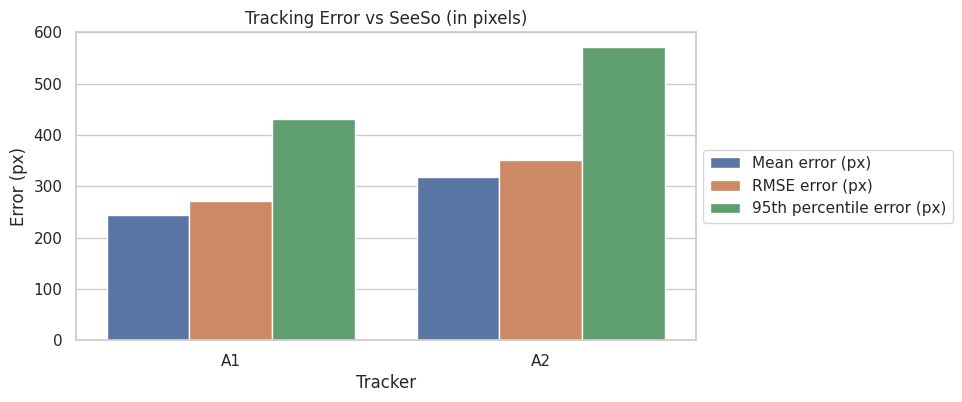

In [18]:
df_err = df_plot[df_plot["tracker"] != "seeso"]

df_err_melt = df_err.melt(
    id_vars="tracker",
    value_vars=["err_mean_px", "err_rmse_px", "err_p95_px"],
    var_name="error_metric",
    value_name="value"
)

df_err_melt["error_metric"] = df_err_melt["error_metric"].map({
    "err_mean_px": "Mean error (px)",
    "err_rmse_px": "RMSE error (px)",
    "err_p95_px": "95th percentile error (px)",
})

plt.figure(figsize=(8,4))
sns.barplot(data=df_err_melt, x="tracker", y="value", hue="error_metric")
plt.title("Tracking Error vs SeeSo (in pixels)")
plt.ylabel("Error (px)")
plt.xlabel("Tracker")
plt.legend(title="", loc="center left", bbox_to_anchor=(1,0.5))
plt.show()


/tmp/ipykernel_17907/908201993.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_sessions[df_sessions["tracker"] != "A2"], x="tracker", y="jitter_mean", palette="flare")


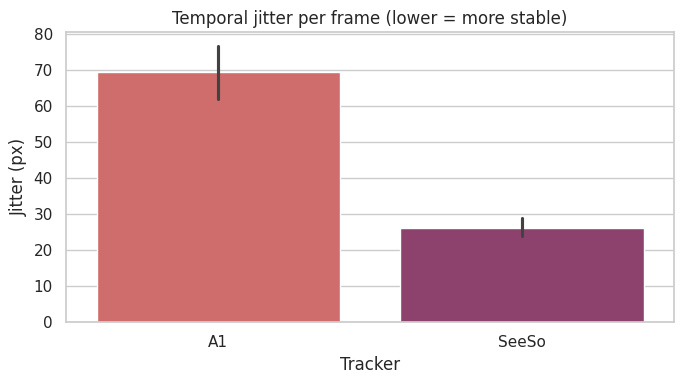

In [20]:
plt.figure(figsize=(7,4))
sns.barplot(data=df_sessions[df_sessions["tracker"] != "A2"], x="tracker", y="jitter_mean", palette="flare")

plt.title("Temporal jitter per frame (lower = more stable)")
plt.ylabel("Jitter (px)")
plt.xlabel("Tracker")
plt.tight_layout()
plt.show()


In [ ]:
display(df_plot)


,tracker,screen_side_agreement_time,roi_time_in_aoi_given_side,roi_time_in_aoi_margin_given_side,err_mean_px,err_rmse_px,err_p95_px
0,pyGaze,0.704092,0.287833,0.471077,236.155667,263.285570,430.725620
1,pyMPIIGaze,0.537903,0.186878,0.431430,309.613625,343.445069,565.624091
2,seeso,1.000000,0.354570,0.447097,0.000000,0.000000,0.000000
